In [202]:
import pandas as pd
import seaborn as sns
from lib.constants import AMINO_ACID_CODE_NAMES, AMINO_ACID_CODES
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

In [284]:
k=3
df = pd.read_csv(f'search/win{k}.csv', keep_default_na=False)
df = df.sort_values('n_matches', ascending=False)
df['prob'] = df['n_matches'] / sum(df['n_matches'])
df.to_csv(f'search/win{k}_sorted.csv', index=False)

In [181]:
print(df.sort_values('n_matches', ascending=False).head(5))
print(df.sort_values('n_matches', ascending=False).tail(5))

      seq  n_matches      prob
0     AAA     149890  0.000824
3115  SSG     145710  0.000801
10    LAA     144364  0.000794
4000  AAL     144288  0.000794
4200  ALL     134201  0.000738
      seq  n_matches      prob
7044  CMW        399  0.000002
1948  HWC        362  0.000002
4897  WCM        288  0.000002
1952  MWC        268  0.000001
6964  CHW        191  0.000001


In [ ]:
fig, ax = plt.subplots()
sns.barplot(data=df, x='seq', y='n_matches', ax=ax)
ax.set_ylabel('Number of matches')
ax.set_xlabel('Amino Acid')
ax.set_title(f'Number of matches for each amino acid in PDB')
ax2 = ax.twinx()
sns.lineplot(data=df, x='seq', y='prob', ax=ax2, color='r')
ax2.set_ylabel('Probability', color='r')
ax2.tick_params(axis='y', labelcolor='r')

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x=range(len(df)), y='n_matches', ax=ax)
ax.set_xlabel('Dimers')
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_title(f'Number of matches for each dimer in PDB')
ax2 = ax.twinx()
sns.lineplot(data=df, x=range(len(df)), y='prob', ax=ax2)
ax2.set_ylabel('Probability')
ax2.tick_params(axis='y')

Text(0.5, 0.98, 'KDE: Number of matches for 8000 Trimers')

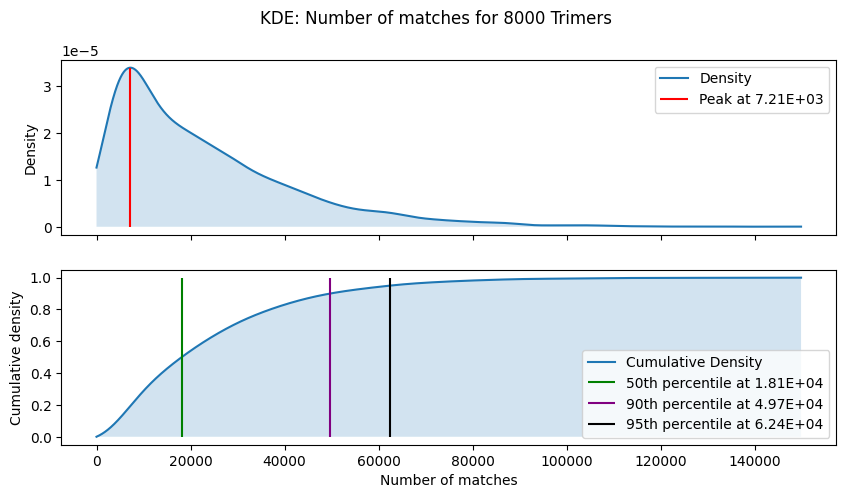

In [241]:
kde = gaussian_kde(df.n_matches.values)
x = np.linspace(0, df.n_matches.max(), 10000)
p = kde(x)
c = np.cumsum(p) / np.sum(p)
peak = x[np.argmax(p)]

fig, axes = plt.subplots(2, sharex=True, figsize=(10, 5))
# sns.kdeplot(data=df, x='n_matches', fill=True, ax=axes[0])
axes[0].plot(x, p, label='Density')
axes[0].fill_between(x, 0, p, alpha=0.2)
axes[0].vlines(peak, 0, p.max(), color='red', label=f'Peak at {peak:.2E}')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[1].plot(x, c, label='Cumulative Density')
perc = x[np.argmax(c > 0.5)]
axes[1].vlines(perc, 0, 1, color='green', label=f'50th percentile at {perc:.2E}')
perc = x[np.argmax(c > 0.9)]
axes[1].vlines(perc, 0, 1, color='purple', label=f'90th percentile at {perc:.2E}')
perc = x[np.argmax(c > 0.95)]
axes[1].vlines(perc, 0, 1, color='black', label=f'95th percentile at {perc:.2E}')
axes[1].fill_between(x, 0, c, alpha=0.2)
axes[1].legend()
axes[1].set_xlabel('Number of matches')
axes[1].set_ylabel('Cumulative density')
fig.suptitle('KDE: Number of matches for 8000 Trimers')

Text(0.5, 25.722222222222214, 'Amino Acid')

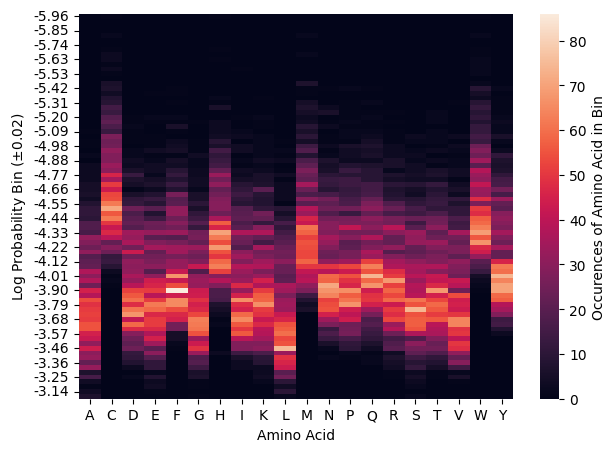

In [348]:
df['log_prob'] = np.log10(df['prob'])
df['bin'] = pd.cut(df.log_prob, bins=80)
df_chars = df.seq.apply(list).explode().reset_index()
df_chars.columns = ['og_index', 'aa']
merged = df_chars.merge(df, left_on='og_index', right_index=True)
char_counts = merged.groupby(['bin', 'aa'], observed=False).size().unstack(fill_value=0)

pm =  r'$\pm$' + f'{char_counts.index[0].length/2:.2f}'
idxs = []
for idx in char_counts.index:
    idxs.append(f'{idx.mid:.2f}')
char_counts.index = idxs
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(char_counts, cbar_kws={'label': 'Occurences of Amino Acid in Bin'})
ax.set_ylabel(f'Log Probability Bin ({pm})')
ax.set_xlabel('Amino Acid')

## Joint Prob - Dimer

In [ ]:
df1 = pd.read_csv('search/win1_sorted.csv', keep_default_na=False)
df2 = pd.read_csv('search/win2_sorted.csv' , keep_default_na=False)
# show joint probability of amino acids vs probability of dimers
# also find probability of dimer given the joint probability of amino acids

probs = df1.set_index('seq').prob
df2['joint_prob'] = df2.seq.apply(lambda x: probs[x[0]] * probs[x[1]])

In [ ]:
fig, ax = plt.subplots()
joint_probs = np.outer(df1.prob, df1.prob)
sns.heatmap(joint_probs, ax=ax, vmin=0, vmax=0.01)
ax.set_title('Joint probability of amino acids')
ax.set_xticklabels(df1.seq)
ax.set_yticklabels(df1.seq);

In [ ]:
probs = []
matches = []
seqs = df1.seq
for aa1 in seqs:
    p = []
    m = []
    for aa2 in seqs:
        p.append(df2.loc[df2.seq == aa1+aa2].prob.values[0])
        m.append(df2.loc[df2.seq == aa1+aa2].n_matches.values[0])
    probs.append(p)
    matches.append(m)
probs = np.array(probs)
matches = np.array(matches)
fig, ax = plt.subplots()
sns.heatmap(probs, ax=ax, vmin=0, vmax=0.01)
ax.set_title('Observed probability of Dimers')
ax.set_xticklabels(seqs)
ax.set_yticklabels(seqs);

In [ ]:
seq = 'HH'
print(
    df1[df1.seq==seq[0]].prob.values[0], 
    df1[df1.seq==seq[1]].prob.values[0],
)
j = df1[df1.seq==seq[0]].prob.values[0]*df1[df1.seq==seq[1]].prob.values[0]
p = df2[df2.seq==seq].prob.values[0]
print(j)
print(p)
print(j/p)

In [ ]:
probs_ratio = joint_probs / probs
fig, ax = plt.subplots()
sns.heatmap(probs_ratio, ax=ax)
ax.set_title('Ratio of Joint Probability to Probability of Dimers')
ax.set_xticklabels(seqs)
ax.set_yticklabels(seqs);

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(np.outer(df1.prob, df1.prob), ax=ax)
ax.set_title('Joint probability of amino acids')
ax.set_xticklabels(df1.seq)
ax.set_yticklabels(df1.seq);

In [ ]:
df2 = df2.sort_values('joint_prob', ascending=False).reset_index(drop=True)
heatmap = df2[['seq','prob', 'joint_prob']].set_index('seq').T
fig, axes = plt.subplots(8, figsize=(7, 5))
# sns.lineplot(data=df2, x=df2.index, y='joint_prob', ax=ax)
# sns.barplot(data=df2.iloc[:100], x=df2.index[:100], y='prob', ax=ax)

m = max(df2.joint_prob.max(), df2.prob.max())
for i in range(8):
    sns.heatmap(heatmap.iloc[:,i*50:(i+1)*50], ax=axes[i], cbar=False, vmin=0, vmax=0.01)
    axes[i].xaxis.set_ticks_position('top')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', which='major', labelsize=5, length=0, rotation=0)
    axes[i].set_yticks([])
    axes[i].set_yticklabels([])
axes[-1].set_xlabel('Dimers')
plt.tight_layout()

## Joint Prob - Trimer

In [125]:
df1 = pd.read_csv('search/win1_sorted.csv', keep_default_na=False)
df3 = pd.read_csv('search/win3_sorted.csv' , keep_default_na=False)
log_probs = np.log10(df1.set_index('seq').prob)
df3['log_prob'] = np.log10(df3.prob)
df3['log_joint_prob'] = df3.seq.apply(lambda x: np.sum([log_probs[aa] for aa in x]))
df3['log_probs_ratio'] = df3.log_joint_prob - df3.log_prob
df3['probs_ratio'] = 10**df3.log_probs_ratio
df3['joint_prob'] = 10**df3.log_joint_prob

In [149]:
df3.sort_values('prob', ascending=False).head(5)

,seq,n_matches,prob,log_prob,log_joint_prob,log_probs_ratio,probs_ratio,joint_prob
0,AAA,149890,0.000824,-3.083845,-3.324657,-0.240813,0.574364,0.000474
1,SSG,145710,0.000801,-3.096128,-3.531898,-0.435770,0.366632,0.000294
2,LAA,144364,0.000794,-3.100159,-3.243769,-0.143611,0.718438,0.000570
3,AAL,144288,0.000794,-3.100387,-3.243769,-0.143382,0.718816,0.000570
4,ALL,134201,0.000738,-3.131862,-3.162881,-0.031020,0.931066,0.000687


Text(0, 0.5, 'Observed Probability')

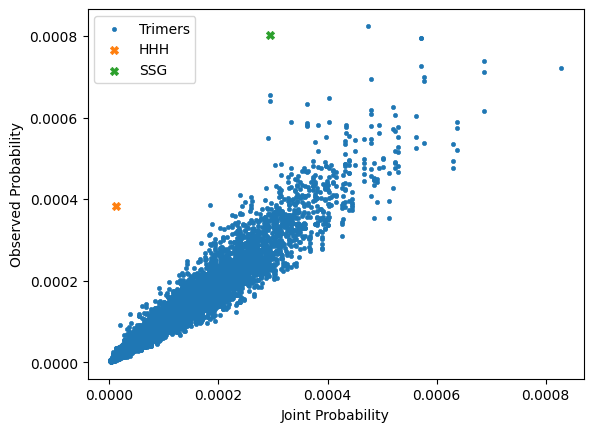

In [152]:
fig, ax = plt.subplots()
sns.scatterplot(data=df3, x='joint_prob', y='prob', marker='.', ax=ax, edgecolor=None, label='Trimers')
sns.scatterplot(data=df3[df3.seq=='HHH'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='HHH')
sns.scatterplot(data=df3[df3.seq=='SSG'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='SSG')
ax.legend()
ax.set_xlabel('Joint Probability')
ax.set_ylabel('Observed Probability')

In [109]:
df3.sort_values('probs_ratio', ascending=False).head(5)

,seq,n_matches,prob,log_prob,joint_prob,log_probs_ratio,probs_ratio
7999,CHW,191,0.000001,-5.978584,-5.453098,0.525486,3.353406
7990,CIW,517,0.000003,-5.546127,-5.053186,0.492941,3.111291
7702,PCE,2241,0.000012,-4.909176,-4.486211,0.422965,2.648285
7937,WPM,1029,0.000006,-5.247202,-4.862788,0.384414,2.423341
7715,DPC,2192,0.000012,-4.918777,-4.553240,0.365537,2.320260


In [ ]:
# plot kde dist for one bad protein and one good protein

# Hydrophobic Index

In [154]:
# https://www.sigmaaldrich.com/US/en/technical-documents/technical-article/protein-biology/protein-structural-analysis/amino-acid-reference-chart
hydrophobic_s = """\
Leu 100 Phe 100
Ile 100 Ile 99
Phe 92 Trp 97
Trp 84 Leu 97
Val 79 Val 76
Met 74 Met 74
Cys 52 Tyr 63
Tyr 49 Cys 49
Ala 47 Ala 41
Thr 13 Thr 13
Glu 8 His 8
Gly 0 Gly 0
Ser -7  Ser -5
Gln -18 Gln -10
Asp -18 Asp -55
Arg -26 Arg -14
Lys -37 Lys -23
Asn -41 Asn -28
His -42 Glu -31
Pro -46 Pro -46\
"""
hydrophobic_index_ph2 = {AMINO_ACID_CODES[l.split()[0].upper()]:l.split()[1] for l in hydrophobic_s.split('\n')}
hydrophobic_index_ph7 = {AMINO_ACID_CODES[l.split()[2].upper()]:l.split()[3] for l in hydrophobic_s.split('\n')}

In [160]:
df = pd.read_csv('search/win1_sorted.csv', keep_default_na=False)

In [161]:
df['h_2'] = df.seq.apply(lambda x: np.sum([int(hydrophobic_index_ph2[aa]) for aa in x]))
df['h_7'] = df.seq.apply(lambda x: np.sum([int(hydrophobic_index_ph7[aa]) for aa in x]))

Text(0, 0.5, 'Number of matches')

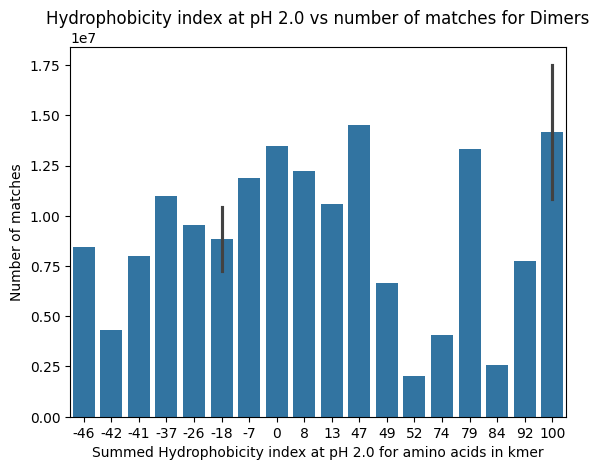

In [174]:
fig, ax = plt.subplots()
sns.barplot(data=df, x='h_2', y='n_matches', ax=ax)
# sns.scatterplot(data=df, x='h_2', y='n_matches', ax=ax, marker='o')
ax.set_title('Hydrophobicity index at pH 2.0 vs number of matches for Dimers')
ax.set_xlabel('Summed Hydrophobicity index at pH 2.0 for amino acids in kmer')
ax.set_ylabel('Number of matches')
# sns.scatterplot(data=df, x='h_7b', y='n_matches')